In [2]:
import pandas as pd
import pickle as pkl
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [4]:
def label_class(row, option):

    if option == 'DX':
        if row['DX'] == 'Dementia':
            return 2
        if row['DX'] == 'MCI':
            return 1
        if row['DX'] == 'CN':
            return 0
    
    elif option == 'APOE4':
        if row['APOE4'] == 2:
            return 1
        elif row['APOE4'] == 1:
            return 1
        elif row['APOE4'] == 0:
            return 0
        
    if option == 'APOE4+DX':
        if row['APOE4+'] == 1:
            if row['DX'] == 'Dementia':
                return 1
            if row['DX'] == 'CN':
                return 0
    
    if option == 'APOE4-DX':
        if row['APOE4+'] == 0:
            if row['DX'] == 'Dementia':
                return 1
            if row['DX'] == 'CN':
                return 0
        
    if option == 'PETandDX':
        if row['AV45+'] == 1 and row['DX'] == 'Dementia':
            return 1
        if row['AV45+'] == 0 and row['DX'] == 'CN':
            return 0
        if np.isnan(row['AV45+']):
            if row['PIB+'] == 1 and row['DX'] == 'Dementia':
                return 1
            if row['PIB+'] == 0 and row['DX'] == 'CN':
                return 0
    
    if option == 'PET':
        if row['AV45+'] == 1:
            return 1
        if row['AV45+'] == 0:
            return 0
        if np.isnan(row['AV45+']):
            if row['PIB+'] == 1:
                return 1
            if row['PIB+'] == 0:
                return 0
    
    if option == 'TAU':
        if np.isnan(row['TAU_slope']) == False:
            return row['TAU_slope']

    if option == 'PTAU':
        if np.isnan(row['PTAU_slope']) == False:
            return row['PTAU_slope']
    
    if option == 'FDG':
        if np.isnan(row['FDG_slope']) == False:
            return row['FDG_slope']

    if option == 'SCORE':
        if np.isnan(row['AV45_scoring']) == False:
            return row['AV45_scoring']
        if np.isnan(row['AV45_scoring']):
            if np.isnan(row['PIB_scoring']) == False:
                return row['PIB_scoring']
    
    if option == 'SCORE+':
        if row['AV45_scoring'] >= 1:
            return 1
        if row['AV45_scoring'] < 1:
            return 0
        if np.isnan(row['AV45_scoring']):
            if row['PIB_scoring'] >= 1:
                return 1
            if row['PIB_scoring'] < 1:
                return 0
    
    if option == 'Phenotype':
        if row['Phenotype'] == 1:
            return 1
        if row['Phenotype'] == 0:
            return 0

def create_class_ADNI(df, option):

    
    df['y'] = df.apply (lambda row: label_class(row, option), axis=1)

    to_drop = list(df.columns)[-27:-1]
    df.drop(columns=to_drop, inplace=True)
    df_notna = df[df['y'].notna()]

    # print()
    # print(df_notna)
    # print()

    print('Class distribution:')
    print(df['y'].value_counts())

    return df_notna

def create_class_LOAD(df, option):

    
    df['y'] = df['Phenotype']
    to_drop = ['FID', 'father_IID', 'mother_IID', 'Sex', 'Phenotype']
    df.drop(columns=to_drop, inplace=True)
    df_notna = df[df['y'].notna()]

    df_notna['y'].replace({2:1, 1:0}, inplace=True)

    # print()
    # print(df_notna)
    # print()

    print('Class distribution:')
    print(df_notna['y'].value_counts())

    return df_notna

In [10]:
file = '/home/laura/Documents/DATASETS/table_datasets/AD_PPI_missense_with_biomarkers.csv'
data = pd.read_csv(file, index_col = 0)
data_wclass = create_class_ADNI(data, 'PET') # or PET&DX

x = data_wclass.drop(columns=['y'])
x = x['APOE']

y = data_wclass['y']

x.index = x.index.str.upper()
# x.reset_index(inplace=True)
# x = x.drop(['index'], axis=1)
# print(x)

f = open(f'/home/laura/Documents/CODE/APP_genetics/ppa-graphs/Spektral_models/split_PET.pkl', 'rb')
split_dict = pkl.load(f)
f.close()

tr_idx = split_dict['train']
te_idx = split_dict['test']

x_train, x_test = x.iloc[tr_idx], x.iloc[te_idx]
y_train, y_test = y[tr_idx], y[te_idx]

print(x_train)
# print(x_test.index)

# Class distribution within each split
print()
print(f'Train set\n{y_train.value_counts()}')
print(f'Test set\n{y_test.value_counts()}')

x_train = np.array(x_train).reshape(-1, 1)
x_test = np.array(x_test).reshape(-1, 1)

scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

logreg = LogisticRegression()
logreg.fit(x_train_scaled, y_train)

y_prob = logreg.predict_proba(x_test_scaled)
# print(y_prob)

y_pred = logreg.predict(x_test_scaled)
acc = metrics.accuracy_score(y_test, y_pred)
pre = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1  = metrics.f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob[:, 1])
print('ACC on test set:', acc)
print('PRE on test set:', pre)
print('REC on test set:', rec)
print('F1  on test set:', f1)
print('AUC on test set:', auc)

cm = metrics.confusion_matrix(y_test, y_pred)
print()
print(cm)

print()
print(classification_report(y_test, y_pred))

Class distribution:
1.0    410
0.0    316
Name: y, dtype: int64
099_S_4565    1.0
032_S_4386    1.0
128_S_4607    2.0
037_S_4030    2.0
098_S_4275    0.0
             ... 
006_S_0731    1.0
033_S_4179    2.0
021_S_4335    0.0
016_S_2031    1.0
023_S_4448    1.0
Name: APOE, Length: 653, dtype: float64

Train set
1.0    369
0.0    284
Name: y, dtype: int64
Test set
1.0    41
0.0    32
Name: y, dtype: int64
ACC on test set: 0.6164383561643836
PRE on test set: 0.6
REC on test set: 0.9512195121951219
F1  on test set: 0.7358490566037735
AUC on test set: 0.6894054878048781

[[ 6 26]
 [ 2 39]]

              precision    recall  f1-score   support

         0.0       0.75      0.19      0.30        32
         1.0       0.60      0.95      0.74        41

    accuracy                           0.62        73
   macro avg       0.68      0.57      0.52        73
weighted avg       0.67      0.62      0.54        73



In [6]:
file = '/home/laura/Documents/DATASETS/table_datasets/AD_PPI_missense_with_biomarkers.csv'
data = pd.read_csv(file, index_col = 0)
data_wclass = create_class_ADNI(data, 'PETandDX') # or PET&DX

x = data_wclass.drop(columns=['y'])
x = x['APOE']

y = data_wclass['y']

x.index = x.index.str.upper()
# x.reset_index(inplace=True)
# x = x.drop(['index'], axis=1)
# print(x)

f = open(f'/home/laura/Documents/CODE/APP_genetics/ppa-graphs/Spektral_models/split_PETandDX.pkl', 'rb')
split_dict = pkl.load(f)
f.close()

tr_idx = split_dict['train']
te_idx = split_dict['test']

x_train, x_test = x.iloc[tr_idx], x.iloc[te_idx]
y_train, y_test = y[tr_idx], y[te_idx]

print(x_train)
# print(x_test.index)

# Class distribution within each split
print()
print(f'Train set\n{y_train.value_counts()}')
print(f'Test set\n{y_test.value_counts()}')

x_train = np.array(x_train).reshape(-1, 1)
x_test = np.array(x_test).reshape(-1, 1)

scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

logreg = LogisticRegression()
logreg.fit(x_train_scaled, y_train)

y_prob = logreg.predict_proba(x_test_scaled)
# print(y_prob)

y_pred = logreg.predict(x_test_scaled)
acc = metrics.accuracy_score(y_test, y_pred)
pre = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1  = metrics.f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob[:, 1])
print('ACC on test set:', acc)
print('PRE on test set:', pre)
print('REC on test set:', rec)
print('F1  on test set:', f1)
print('AUC on test set:', auc)

cm = metrics.confusion_matrix(y_test, y_pred)
print()
print(cm)

print()
print(classification_report(y_test, y_pred))

Class distribution:
1.0    182
0.0    135
Name: y, dtype: int64
031_S_2018    1.0
011_S_4105    0.0
012_S_4545    2.0
018_S_2133    2.0
116_S_4167    2.0
             ... 
022_S_4173    2.0
006_S_4515    1.0
130_S_4415    1.0
129_S_0778    2.0
018_S_4399    2.0
Name: APOE, Length: 285, dtype: float64

Train set
1.0    164
0.0    121
Name: y, dtype: int64
Test set
1.0    18
0.0    14
Name: y, dtype: int64
ACC on test set: 0.75
PRE on test set: 0.7272727272727273
REC on test set: 0.8888888888888888
F1  on test set: 0.7999999999999999
AUC on test set: 0.6825396825396824

[[ 8  6]
 [ 2 16]]

              precision    recall  f1-score   support

         0.0       0.80      0.57      0.67        14
         1.0       0.73      0.89      0.80        18

    accuracy                           0.75        32
   macro avg       0.76      0.73      0.73        32
weighted avg       0.76      0.75      0.74        32



# Baseline model in T Gen II dataset

In [7]:
file = '/home/laura/Documents/DATASETS/table_datasets/AD_PPI_missense_with_biomarkers_LOAD.csv'
data = pd.read_csv(file, index_col = 0)
data_wclass = create_class_LOAD(data, 'Phenotype') # or PET&DX
data_wclass

x = data_wclass.drop(columns=['y'])
x = x['APOE']

y = data_wclass['y']

x.index = x.index.str.upper()

f = open(f'/home/laura/Documents/CODE/APP_genetics/ppa-graphs/Spektral_models/split_Phenotype.pkl', 'rb')
split_dict = pkl.load(f)
f.close()

tr_idx = split_dict['train']
te_idx = split_dict['test']

x_train, x_test = x.iloc[tr_idx], x.iloc[te_idx]
y_train, y_test = y[tr_idx], y[te_idx]

print(x_train)
# print(x_test.index)

# Class distribution within each split
print()
print(f'Train set\n{y_train.value_counts()}')
print(f'Test set\n{y_test.value_counts()}')

x_train = np.array(x_train).reshape(-1, 1)
x_test = np.array(x_test).reshape(-1, 1)

scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

logreg = LogisticRegression()
logreg.fit(x_train_scaled, y_train)

y_prob = logreg.predict_proba(x_test_scaled)
# print(y_prob)

y_pred = logreg.predict(x_test_scaled)
acc = metrics.accuracy_score(y_test, y_pred)
pre = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1  = metrics.f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob[:, 1])
print('ACC on test set:', acc)
print('PRE on test set:', pre)
print('REC on test set:', rec)
print('F1  on test set:', f1)
print('AUC on test set:', auc)

cm = metrics.confusion_matrix(y_test, y_pred)
print()
print(cm)

print()
print(classification_report(y_test, y_pred))

Class distribution:
1.0    1014
0.0     585
Name: y, dtype: int64
WGACON148    0.0
WGAAD482     1.0
WGAAD264     1.0
WGAAD8       1.0
EURCON35     1.0
            ... 
UKAD18       0.0
WGACON239    0.0
WGAAD463     1.0
EURAD241     1.0
EURCON70     0.0
Name: APOE, Length: 1439, dtype: float64

Train set
1.0    913
0.0    526
Name: y, dtype: int64
Test set
1.0    101
0.0     59
Name: y, dtype: int64
ACC on test set: 0.66875
PRE on test set: 0.7553191489361702
REC on test set: 0.7029702970297029
F1  on test set: 0.7282051282051281
AUC on test set: 0.6266152038932706

[[36 23]
 [30 71]]

              precision    recall  f1-score   support

         0.0       0.55      0.61      0.58        59
         1.0       0.76      0.70      0.73       101

    accuracy                           0.67       160
   macro avg       0.65      0.66      0.65       160
weighted avg       0.68      0.67      0.67       160



# Miscellanea

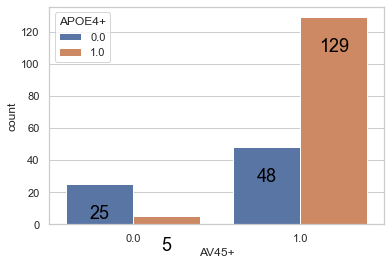

In [22]:
dementia = data.loc[data['DX'] == 'Dementia']
dementia

ax = sns.countplot(x='AV45+', hue='APOE4+', data=dementia)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='black', size=18)
plt.show()

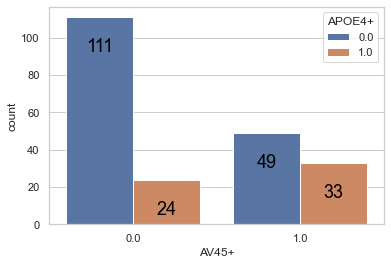

In [23]:
cn = data.loc[data['DX'] == 'CN']
cn

ax = sns.countplot(x='AV45+', hue='APOE4+', data=cn)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='black', size=18)
plt.show()

In [21]:
petdx = pd.concat([data_wclass, data], axis=1)
petdx

,ADAM10,APOC1,APOE,BACE1,BAX,BDNF,BIN1,CRH,ENO1,EPHA1,...,PTAU+,APOE4+,AV45_scoring,PIB_scoring,TAU_slope,TAU_rvalue,PTAU_slope,PTAU_rvalue,FDG_slope,FDG_rvalue
003_S_1057,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.006288,-0.986133
136_S_0873,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
003_S_1074,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.000659,-0.568801
027_S_0074,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.001178,0.666231
016_S_1117,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,...,1.0,0.0,1.310022,NaN,2.486261,0.951749,0.172793,0.956438,-0.002594,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
037_S_4432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,0.568750,0.660856,0.034792,0.596698,NaN,NaN
136_S_4408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.950283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
068_S_0473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135_S_4676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.374145,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
pet = pd.concat([data_wclass, data], axis=1)
pet

,ADAM10,APOC1,APOE,BACE1,BAX,BDNF,BIN1,CRH,ENO1,EPHA1,...,PTAU+,APOE4+,AV45_scoring,PIB_scoring,TAU_slope,TAU_rvalue,PTAU_slope,PTAU_rvalue,FDG_slope,FDG_rvalue
003_S_1057,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.006288,-0.986133
003_S_0908,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.780471,NaN,0.146429,0.918055,0.009464,0.448380,-0.001908,-0.987019
003_S_1122,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.001430,-0.690545
136_S_0873,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130_S_0886,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,...,0.0,0.0,1.020895,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
009_S_4564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128_S_4603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
007_S_1222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
037_S_4432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,0.568750,0.660856,0.034792,0.596698,NaN,NaN


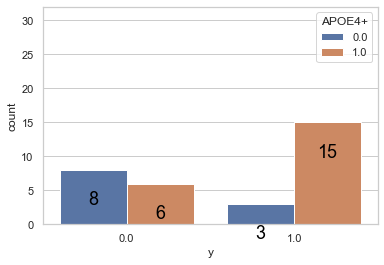

In [25]:
df = petdx.loc[x_test.index]

ax = sns.countplot(x='y', hue='APOE4+', data=df) # PET&DX
plt.ylim(0, 32)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='black', size=18)
plt.show()
plt.show()

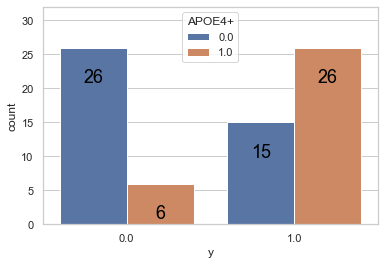

In [38]:
df = pet.loc[x_test.index]

ax = sns.countplot(x='y', hue='APOE4+', data=df) # PET&DX
plt.ylim(0, 32)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='black', size=18)
plt.show()
plt.show()

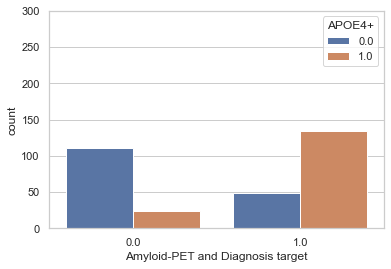

In [67]:
ax = sns.countplot(x='y', hue='APOE4+', data=petdx) # PET&DX
plt.ylim(0, 300)
plt.xlabel('Amyloid-PET and Diagnosis target')
plt.show()

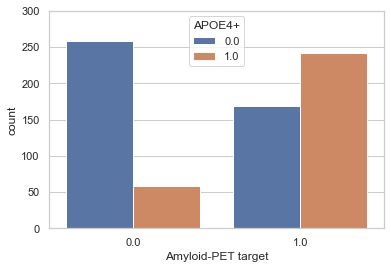

In [68]:
ax = sns.countplot(x='y', hue='APOE4+', data=pet) # PET
plt.ylim(0, 300)
plt.xlabel('Amyloid-PET target')
plt.show()

Text(0.5, 1.0, 'APOE missense variants distribution with PET class')

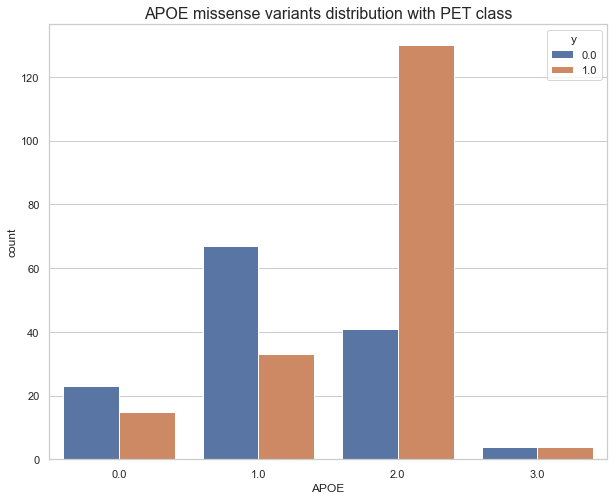

In [25]:
plt.figure(figsize=(10, 8))
sns.countplot(x='APOE', hue='y', data=data_wclass)
plt.title('APOE missense variants distribution with PET class', fontsize=16)
# plt.savefig('figures/APOE_distrib_PET.png', dpi=300)